In [1]:
!pip install spatial_kde

  Using cached Shapely-1.8.5.post1-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (43 kB)
  Using cached geopandas-0.10.2-py2.py3-none-any.whl.metadata (935 bytes)
Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
Using cached Shapely-1.8.5.post1-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Attempting uninstall: Shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-mobility 1.3.1 requires python-igraph<0.10.0,>=0.9.1, which is not installed.
libpysal 4.8.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is 

In [2]:
import sys
print(sys.executable)

/opt/conda/envs/gds/bin/python


In [3]:
pip install shapely==2.0.1 osmnx==1.7.0

  Using cached shapely-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
Using cached shapely-2.0.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.5.post1
    Uninstalling Shapely-1.8.5.post1:
      Successfully uninstalled Shapely-1.8.5.post1
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.10.2
    Uninstalling geopandas-0.10.2:
      Successfully uninstalled geopandas-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-mobility 1.3.1 requires python-igraph<0.10.0,>=0.9.1, which is not installed.
scikit-mobility 1.3.1 requires folium==0.12.1.post1, but you have folium 0.14.0 w

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Downloading network

In [2]:
USOS_ZONA_7 = gpd.read_file("Distrito_Zona7.geojson")

In [6]:
print(USOS_ZONA_7.crs)

EPSG:32613


In [7]:
USOS_ZONA_7.shape

(1, 4)

<Axes: >

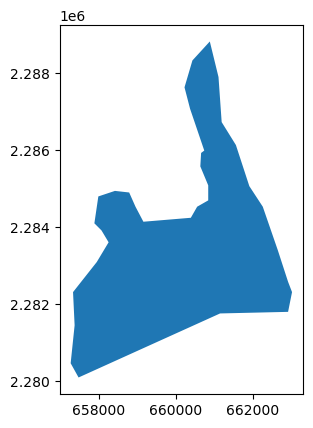

In [8]:
USOS_ZONA_7.plot()

In [7]:
from aup import utils
import geopandas as gpd
from sqlalchemy import text

def gdf_from_query(query, geometry_col="geometry", index_col=None):
    """
    Versión mejorada de la función original que maneja correctamente las geometrías WKB
    
    Arguments:
        query (str): SQL query to get the data
        geometry_col (str): Name of the geometry column
        index_col (str): Name of the index column
        
    Returns:
        df (geoPandas.GeoDataFrame): GeoDataFrame with the table from the database.
    """
    engine = utils.db_engine()
    utils.log("Getting data from DB")
    
    try:
        # Usar text() para asegurar que la consulta sea ejecutable
        df = gpd.GeoDataFrame.from_postgis(
            text(query),  # Convertir la consulta a objeto ejecutable
            engine,
            geom_col=geometry_col,
            index_col=index_col
        )
        utils.log("Data retrieved successfully")
        return df
        
    except Exception as e:
        utils.log(f"Error retrieving data: {str(e)}", level="ERROR")
        raise
    finally:
        engine.dispose()

In [8]:
# Convertir la geometría del polígono en WKT (para usar SQL en la query)
poly_wkt = USOS_ZONA_7.dissolve().geometry.iloc[0].wkt
# print(poly_wkt)  # Verificar si genera un WKT válido

In [9]:
schema = "denue"
table = "denue_2022"

manzana = "manzana"
entidad = "cve_ent"
localidad = "cve_loc"
municipio = "cve_mun"
id = "id"
latitud = "latitud"
longitud = "longitud"
codigo_act = "codigo_act"
ageb = "ageb"
per_ocu = "per_ocu"


# Crear la consulta manteniendo el mismo CRS
query_censo = f"""
SELECT 
  "{id}", 
  "{entidad}",
  "{localidad}",
  "{manzana}",
  "{municipio}",
  "{latitud}",
  "{longitud}",
  "{codigo_act}",
  "{ageb}",
  "{per_ocu}",
  "geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta
Denue = gdf_from_query_wkt(query_censo, geometry_col='geometry')

# Asegurar que el GeoDataFrame resultante tenga el CRS correcto
Denue = Denue.to_crs("EPSG:32613")


print(Denue.shape)
Denue.head()

Error ejecutando consulta: ParseException: Unknown type: '0101000020E6100000C9D4345A94DC59C03C8176A822A53440'


GEOSException: ParseException: Unknown type: '0101000020E6100000C9D4345A94DC59C03C8176A822A53440'

In [ ]:
print(Denue.is_valid.sum())  # Geometrías válidas
print(Denue.geometry.is_empty.sum())  # Geometrías vacías

In [ ]:
# Verificar coordenadas extremas
print("\nRango de coordenadas USOS_ZONA_7:")
print(USOS_ZONA_7.total_bounds)
print("\nRango de coordenadas Denue:")
print(Denue.total_bounds)

## Clasificar las distintas actividades económicas con base en su terminación en "codigo_act" basándonos en el Directorio Estadístico Nacional de Unidades Económicas

In [ ]:
# Función para clasificar según la terminación de codigo_act
def asignar_tipo(codigo):
    if pd.isna(codigo):  # Si está vacío
        return 'Sin código'
    
    # Asegurar que sea string para evaluar el código
    codigo_str = str(codigo).strip()

    if not codigo_str.isdigit():
        return 'Código inválido'
    
    # Define tus conjuntos de códigos
    industria = {'11', '21', '23', '31', '32', '33', '55'}
    
    servicios = {'22', '48', '49', '52', '53', '54', '56', '72',
                 '81'}
    
    comercio = {'43', '46'}
    
    cultural_recreativo = {'51','71'}
    
    educacion = {'61'}
    
    salud = {'62'}

    gobierno = {'93'}
    
    # Verificar si el código está en alguno de los conjuntos
    if codigo_str[:2] in industria:
        return 'Industria'
    elif codigo_str[:2] in servicios:
        return 'Servicios'
    elif codigo_str[:2] in comercio:
        return 'Comercio'
    elif codigo_str[:2] in cultural_recreativo:
        return 'Cultural/Recreativo'
    elif codigo_str[:2] in educacion:
        return 'Educación'
    elif codigo_str[:2] in salud:
        return 'Salud'
    elif codigo_str[:2] in gobierno:
        return 'Gobierno'
    else:
        return 'Desconocido'

# Aplica la función al DataFrame
Denue['tipo_act'] = Denue['codigo_act'].apply(asignar_tipo)

In [ ]:
Denue.head(3)

In [ ]:
Denue["tipo_act"].unique()

In [ ]:
desconocidos = Denue[Denue['tipo_act'] == 'Desconocido']
desconocidos

### Relación espacio -> espacio

#### Mostrar de manera completa las relaciones y jerarquías entre los distintos espacios

In [ ]:
jerarquia_completa = Denue[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']].sort_values(by=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'])
jerarquia_completa.head(10)

In [ ]:
jerarquia_completa.shape

In [ ]:
conteo_manzanas = jerarquia_completa.groupby(['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']) \
    .size().reset_index(name='cont_manzanas') #  Contar cuántas manzanas hay por agrupación y convertimos a string

In [ ]:
conteo_manzanas.head(5)

In [ ]:
conteo_manzanas["cont_manzanas"].unique()

In [ ]:
jerarquia_completa['cod_16d'] = (
    jerarquia_completa['cve_ent'].astype(str).str[:2] +
    jerarquia_completa['cve_mun'].astype(str).str[:3] +
    jerarquia_completa['cve_loc'].astype(str).str[:4] +
    jerarquia_completa['ageb'].astype(str).str[:4] +
    jerarquia_completa['manzana'].astype(str).str[:3]
)

In [ ]:
jerarquia_completa

In [ ]:
Denue_completo = Denue.merge(
    jerarquia_completa)

Denue_completo.head(3)

In [ ]:
Denue_completo.shape

## Importar las manzanas de censo

In [ ]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"

entidad = "cve_ent"
localidad = "cve_loc"
municipio = "cve_mun"
manzana = "cvegeo_mza"
ageb = "cve_ageb"
ambito = "ambito"
tipomza = "tipomza"
pobtot = "pobtot"

query_censo = f"""
SELECT 
"{entidad}",
"{manzana}",
"{localidad}",
"{municipio}",
"{ageb}",
"{ambito}",
"{tipomza}",
"{pobtot}",
"geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta y cargar los datos en un GeoDataFrame
censo_denue = aup.gdf_from_query(query_censo, geometry_col='geometry')
censo_denue = censo_denue.to_crs("EPSG:32613")

print(censo_denue.shape)
censo_denue.head()

### Contabilizar cuántas personas hay ejerciendo cada actividad económica

In [ ]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [ ]:
Denue_completo['per_ocu_num'] = Denue_completo.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))
Denue_completo.head(2)

### Hacer el match entre las manzanas del denue y las manzanas del censo

In [ ]:
censo_denue.rename(columns = {"cve_ageb": "ageb"} , inplace = True)
censo_denue.rename(columns = {"cvegeo_mza": "manzana"} , inplace = True)

In [ ]:
# Claves únicas del DENUE (para verificar coincidencias)
claves_denue = Denue_completo[
    ['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']]

In [ ]:
# Añadir columna binaria (1 si existe en DENUE, 0 si no)
censo_denue['tiene_denue'] = censo_denue.apply(
    lambda row: 1 if (
        (claves_denue['cod_16d'] == row['manzana'])
    ).any() else 0,
    axis=1
)

In [ ]:
censo_denue.head(2)

In [ ]:
censo_sin_denue = censo_denue[censo_denue['tiene_denue'] == 0]
print(censo_sin_denue.shape)
censo_sin_denue.head(2)

## Crear centroides

In [ ]:
print("Columnas en Denue_completo:", Denue_completo.columns.tolist())
print("CRS de los datos:", manzanas_gdf.crs == Denue_completo.crs)

In [ ]:
# 1. Crear GeoDataFrame de manzanas con centroides únicos
manzanas_gdf = censo_con_denue[
    ['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'geometry']
].drop_duplicates()
manzanas_gdf['centroide'] = manzanas_gdf['geometry'].centroid

# 2. Calcular distancia entre cada establecimiento y su manzana correspondiente
denue_con_distancias = pd.merge(
    Denue_completo[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'geometry', 'codigo_act', 'per_ocu_num']],
    manzanas_gdf[['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana', 'centroide']],
    on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'],
    how='inner'
)

# 3. Calcular la distancia de cada punto al centroide de su manzana
denue_con_distancias['distancia'] = denue_con_distancias['geometry'].distance(denue_con_distancias['centroide'])

# 4. Calcular d_mean por manzana
d_mean_por_manzana = denue_con_distancias.groupby(
    ['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana']
)['distancia'].mean().reset_index(name='d_mean')

# 5. Agregar d_mean a manzanas_gdf
manzanas_gdf = manzanas_gdf.merge(d_mean_por_manzana, on=['cve_ent', 'cve_mun', 'cve_loc', 'ageb', 'manzana'], how='left')

# 6. Análisis final: por manzana, usando intersección espacial
resultados = []
for _, manzana in manzanas_gdf.iterrows():
    establecimientos = Denue_completo[
        Denue_completo['geometry'].within(manzana['geometry'])
    ]
    
    resultados.append({
        'cve_ent': manzana['cve_ent'],
        'cve_mun': manzana['cve_mun'],
        'cve_loc': manzana['cve_loc'],
        'ageb': manzana['ageb'],
        'manzana': manzana['manzana'],
        'd_mean': manzana['d_mean'],
        'total_establecimientos': len(establecimientos),
        'actividades_diferentes': establecimientos['codigo_act'].nunique(),
        'per_ocu_total': establecimientos['per_ocu_num'].sum(),
        'geometry': manzana['geometry']
    })

# 7. Crear GeoDataFrame final
analisis_final = gpd.GeoDataFrame(resultados, geometry='geometry', crs=manzanas_gdf.crs)

# 8. Estadísticas generales
print("\nResumen de análisis:")
print(f"- Total de manzanas analizadas: {len(analisis_final)}")
print(f"- Promedio d_mean: {analisis_final['d_mean'].mean():.2f} m")
print(f"- Establecimientos promedio por manzana: {analisis_final['total_establecimientos'].mean():.2f}")
print(f"- Actividades económicas promedio por manzana: {analisis_final['actividades_diferentes'].mean():.2f}")
print(f"- Personal ocupado promedio por manzana: {analisis_final['per_ocu_total'].mean():.2f}")

## Spatial-kde

In [ ]:
manzana_prueba = manzanas_gdf.iloc[0]

# Filtrar los puntos del DENUE que caen dentro de esa manzana
denue_en_manzana = Denue_completo[
    Denue_completo.within(manzana_prueba['geometry'])
].copy()

# Asegurar que el CRS sea proyectado (no en grados, tipo EPSG:4326)
if denue_en_manzana.crs.is_geographic:
    denue_en_manzana = denue_en_manzana.to_crs(epsg=32613)
    manzana_prueba = gpd.GeoSeries([manzana_prueba['geometry']], crs=manzana_prueba.geometry.crs).to_crs(epsg=32614)

# Ejecutar el KDE solo sobre esos puntos
spatial_kernel_density(
    points=denue_en_manzana,
    radius= (analisis_final['d_mean']/2),
    output_path=os.path.join(output_dir, "kde_manzana_prueba.tif"),
    output_pixel_size=1.0,
    output_driver="GTiff",
    weight_col="per_ocu_num", # Número de personas por ocupación
    scaled=True
)